Import data and combine z-stacks

In [65]:
from jiaoyang_analysis.config import data_dir
import numpy as np
import tifffile

img = tifffile.imread(data_dir / 'selecttest3.tif')
print(img.shape) # (z, channels, y, x)
img_zproj = np.max(img, axis=0) # z-projection with maximum intensity

(12, 3, 1945, 3789)


Import ROIs and apply ROI to image slice

In [66]:
roi = tifffile.imread(data_dir / 'Mask.tif')
mask = roi > 0 # convert to binary mask

img_slice = img_zproj[0, :, :] # first channel (IBA1)
img_roi = np.where(mask, img_slice, 0) # apply mask to image
roi_size = np.count_nonzero(img_roi)

print(f"ROI size: {roi_size} pixels")

ROI size: 933422 pixels


Visualize data using seaborn

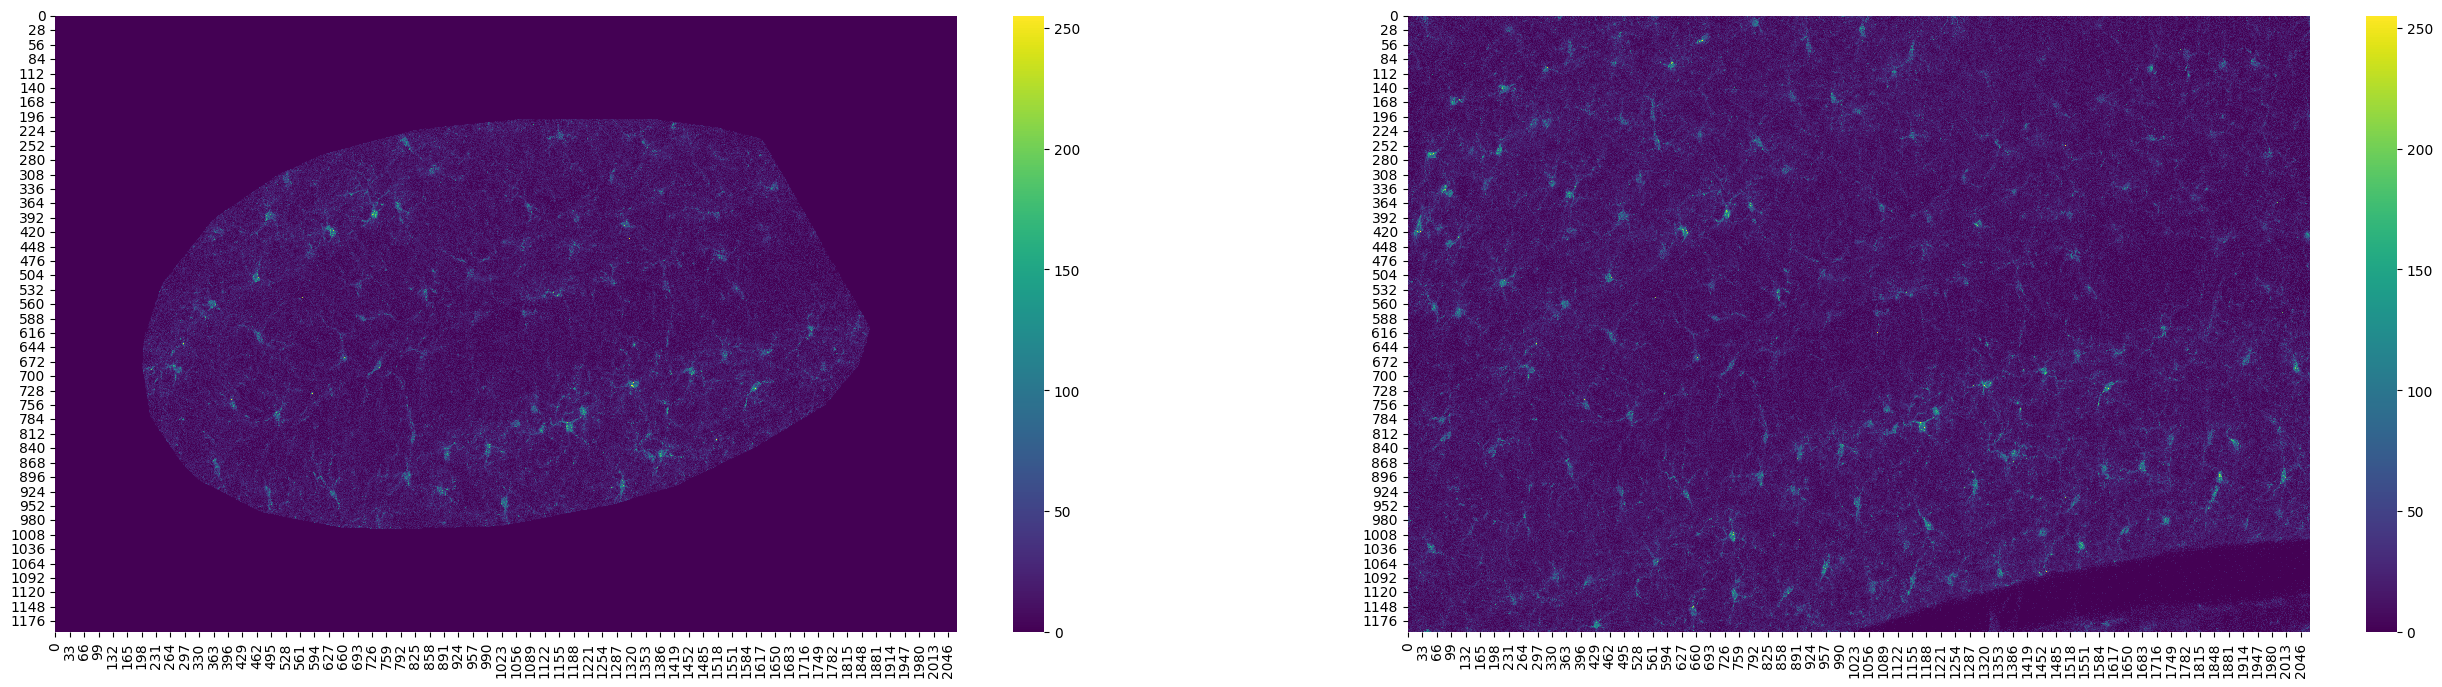

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# crop image around ROI with a buffer
def crop_with_buffer(img, buffer):
    y, x = np.nonzero(img)
    y_min = max(y.min() - buffer, 0)
    y_max = min(y.max() + buffer, img.shape[0])
    x_min = max(x.min() - buffer, 0)
    x_max = min(x.max() + buffer, img.shape[1])
    return img[y_min:y_max, x_min:x_max], (y_min, y_max, x_min, x_max)
img_roi_cropped, coords = crop_with_buffer(img_roi, buffer=200)
img_slice_cropped = img_slice[coords[0]:coords[1], coords[2]:coords[3]]

fig, axes = plt.subplots(1, 2, figsize=(32, 8))
sns.heatmap(img_roi_cropped, square=False, cmap='viridis', ax=axes[0])
sns.heatmap(img_slice_cropped, square=False, cmap='viridis', ax=axes[1])
plt.show()

Detect and label microglia

Detected 122 objects


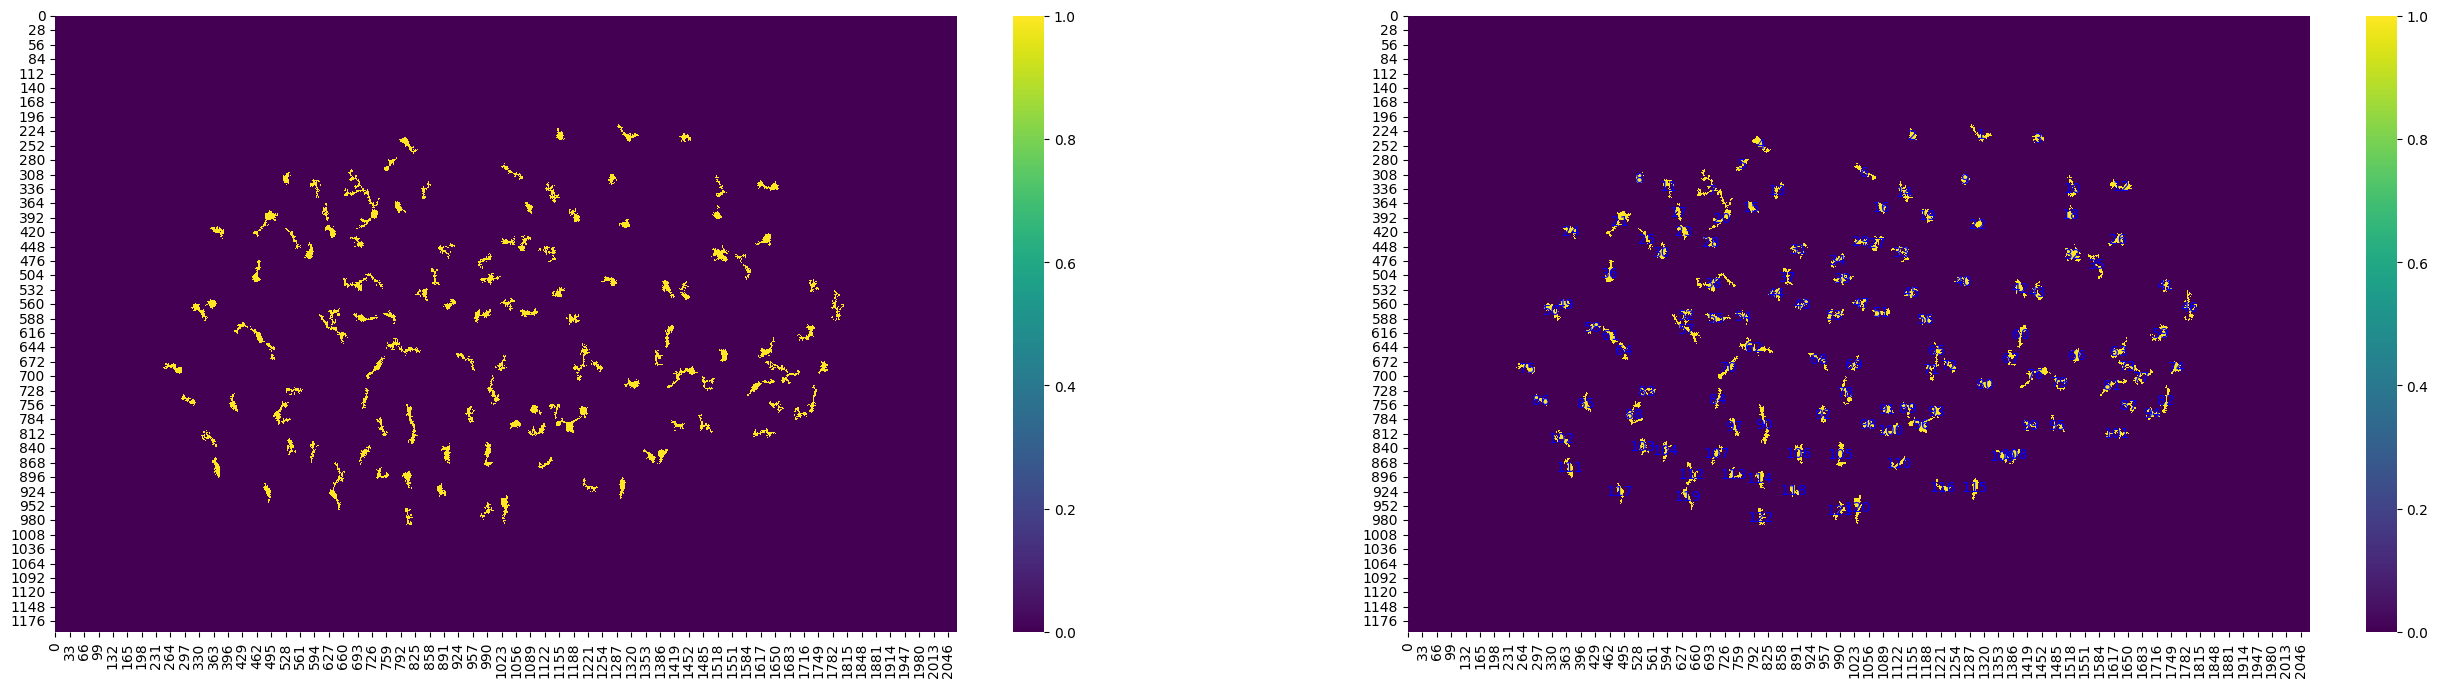

In [92]:
from skimage import filters, measure, morphology, exposure
import seaborn as sns
import matplotlib.pyplot as plt

block_size = 51 # size of the local neighborhood; must be odd
offset = -0.15 # adjusts sensitivity: greater = stricter
local_thresh = filters.threshold_local(img_slice_cropped, block_size=block_size, offset=offset)
binary = img_roi_cropped > local_thresh

binary = morphology.remove_small_objects(binary, min_size=200)  # remove tiny noise
binary = morphology.remove_small_holes(binary, area_threshold=300)

# Assign labels to connected components
labels = measure.label(binary)
props = measure.regionprops(labels)
print("Detected", len(props), "objects")

fig, axes = plt.subplots(1, 2, figsize=(32, 8))
sns.heatmap(binary, square=False, cmap='viridis', ax=axes[0])

# overlay text labels at centroids
for prop in props:
    y, x = prop.centroid  # Note: centroid returns (row, col)
    plt.text(x, y, str(prop.label), color='blue', ha='center', va='center', fontsize=10)

sns.heatmap(binary, square=False, cmap='viridis', ax=axes[1])
plt.show()
